# Install relevant libraries

In [ ]:
# pandas is a library for data manipulation and analysis 
# it offers data structures and operations for manipulating numerical tables and time series 

! pip install pandas

In [ ]:
# scikit-learn is a machine learning library  
# it features various classification, regression and clustering algorithms

! pip install sklearn

# Import data

Dataset is provided as training.mat file. It consists of matrix X with dimensions 200 x 400, with samples in rows and features in columns. The vector c is 200 x 1 and consists of target values 1 and -1. Xtest is a 1000 x 400 matrix whose target values are to be predicted using a trained model.

X and c are first exported from MATLAB as .csv files.

They are imported into this notebook as follows.

In [1]:
import pandas as pd

# read csv files
X = pd.read_csv("X.csv", header=None) 
y = pd.read_csv("c.csv", header=None)

# print dimensions
print(X.shape)
print(y.shape)

(200, 400)
(200, 1)


In [2]:
# print first few rows to ensure that data has been imported correctly

print(X[:5])
print(y[:5])

        0         1         2         3         4         5         6    \
0  0.058769  0.711601  0.958490  1.159877  0.490971 -0.380859  0.031470   
1  0.588283  0.187873 -0.515377  0.368605  0.121498  1.253874  0.736197   
2 -1.649700 -0.505057 -0.442736 -0.509741 -1.122116 -0.637729  0.372541   
3  0.465652  0.681476  0.490944  0.761710  0.238138 -0.700563 -1.399542   
4  1.074260  0.457243  1.146926  0.068267  1.526367 -0.095231  1.037118   

        7         8         9    ...       390       391       392       393  \
0 -0.649862 -0.899371  0.433848  ...  1.231042  0.630582  0.383302  1.705559   
1  1.233126 -0.721073 -1.133487  ... -0.634669  0.281456  0.643510  1.902450   
2 -1.858802 -1.438478  0.111750  ... -1.752426 -1.856998 -0.423999 -0.328754   
3 -0.691599  1.325249  1.802056  ...  1.148982 -0.457527  0.211381 -0.969676   
4  1.409383  2.015187  1.286745  ... -0.175482 -1.475786  0.909587 -0.706439   

        394       395       396       397       398       399  
0  1

# Standardize data

Some machine learning algorithms work better on normalized data, where normalization means subtracting the mean and dividing by the standard deviation for each column.

X is normalized using `StandardScaler()` as follows.

In [3]:
from sklearn import preprocessing

scaler = preprocessing.StandardScaler().fit(X)
X = scaler.transform(X)

# Flatten y vector

The y vector is a column vector but the `sklearn` machine learning functions require y as a row vector.    

The `numpy.ravel()` function, which returns contiguous flattened array (1D array with all the input-array elements), is used to convert the y column vector into a row vector as follows: 

In [20]:
import numpy as np

# convert column to row
y = np.ravel(y)

print(y.shape)

(200,)


# Grid search for feature selection and finding hyperparameters of the models

Grid search is the process of finding optimal values of the hyperparameters by trying all combinations of many possible values using cross-validation based on the accuracy calculated on the validation sets.

Feature selection is done before applying each classification algorithm and the number of features selected, k, is chosen via grid search. Most of the features are not expected to be statistically related to the labels. Since features are much more than the samples, it can be helpful to drop unrelated features to get better results from the machine learning algorithms.

Statistical feature selection methods evaluate the relationship between each input variable and the target variable and select those input variables that have the strongest relationship with the target variable. `SelectKBest` is a function that removes all but the k highest scoring features. It is implemented with the `f_classif()` function that computes the ANOVA F value that indicates the degree of linear dependency between the feature and the target variable.

After selecting the k value for feature selection, hyperparameters of the machine learning models themselves are also selected via grid search. 

Feature selection and model definition are condensed into a pipeline.

This procedure is carried out separately for each machine learning algorithm as follows:

# 1. Logistic Regression

In [5]:
from sklearn.pipeline import make_pipeline
from sklearn.model_selection import StratifiedKFold
from sklearn.feature_selection import SelectKBest
from sklearn.feature_selection import f_classif
from sklearn.linear_model import LogisticRegression
from sklearn.model_selection import GridSearchCV
from sklearn.metrics import accuracy_score
from numpy import mean
from numpy import std

# make a pipeline to select features and apply logistic regression
LR_pipeline = make_pipeline(SelectKBest(score_func=f_classif), LogisticRegression(solver='liblinear', random_state=20))

# k = number of features to use in SelectKBest
k_values = [100, 200, 300, 400]

# C = inverse regularization parameter for ridge or lasso; lowering C strengthens Lambda 
c_values = [100, 10, 1.0, 0.1]

# l1 = lasso; l2 = ridge
penalty = ['l1', 'l2']

# define a grid of parameter values
grid = dict(logisticregression__C=c_values, logisticregression__penalty=penalty, selectkbest__k=k_values)

# define 5-fold cross-validation 
# KFold is a cross-validator that divides the dataset into k folds
# Stratified is to ensure that each fold of dataset has the same proportion of observations with a given label
cv = StratifiedKFold(n_splits=5) 

# GridSearchCV exhaustively generates candidates from a grid of parameter values 
grid_search = GridSearchCV(estimator=LR_pipeline, param_grid=grid, n_jobs=-1, cv=cv)
grid_result = grid_search.fit(X, y)

print("Best CV score: %f using %s" % (grid_result.best_score_, grid_result.best_params_))
    
# define a logistic regression model using the optimal parameter values obtained from the grid search
LR_pipeline = make_pipeline(SelectKBest(score_func=f_classif, k=grid_result.best_params_['selectkbest__k']), 
                        LogisticRegression(penalty=grid_result.best_params_['logisticregression__penalty'], 
                                           solver='liblinear', C=grid_result.best_params_['logisticregression__C'], 
                                           random_state=20))

Best CV score: 0.765000 using {'logisticregression__C': 10, 'logisticregression__penalty': 'l1', 'selectkbest__k': 200}


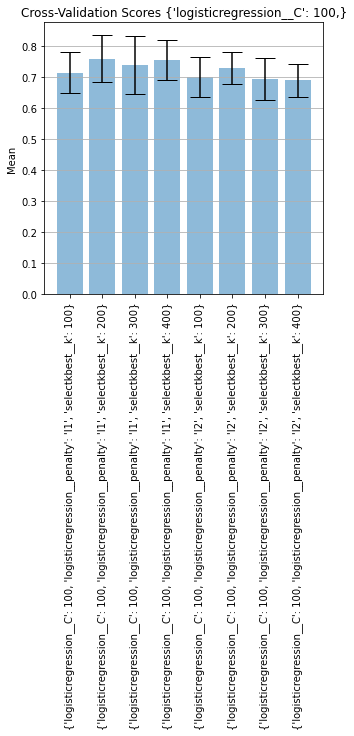

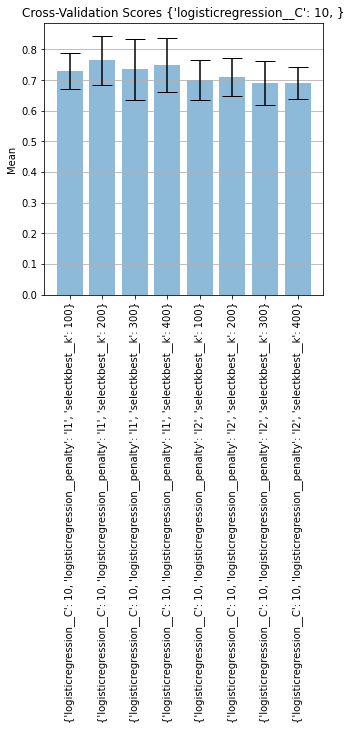

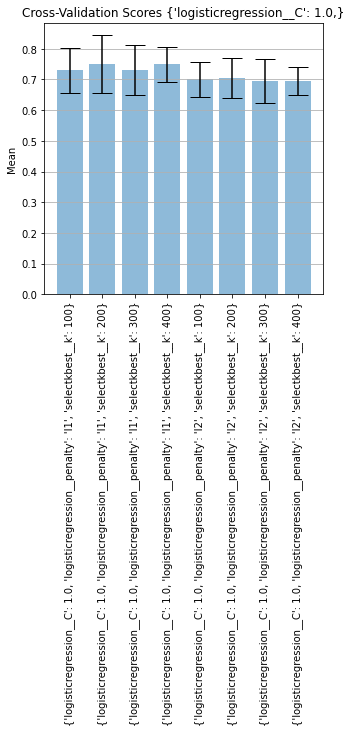

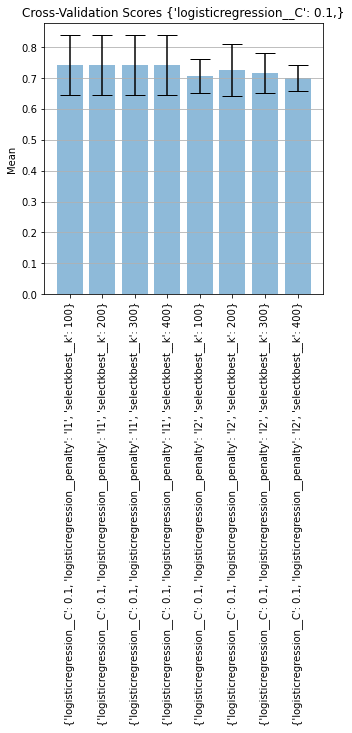

In [6]:
import matplotlib.pyplot as plt
%matplotlib inline

for i in range(0,len(grid_result.cv_results_['params']),8):
    fig, ax = plt.subplots(figsize=(5,5))
    ax.bar(np.arange(len(grid_result.cv_results_['params'][i:i+8])),
           grid_result.cv_results_['mean_test_score'][i:i+8],
           yerr=grid_result.cv_results_['std_test_score'][i:i+8],
           align='center', alpha=0.5, ecolor='black', capsize=10)
    ax.set_ylabel('Mean')
    ax.set_xticks(np.arange(len(grid_result.cv_results_['params'][i:i+8])))
    ax.set_xticklabels(grid_result.cv_results_['params'][i:i+8], 
                       rotation=90)
    ax.set_title('Cross-Validation Scores '+str(grid_result.cv_results_['params'][i])[0:30]+'}')
    ax.yaxis.grid(True)

    #plt.savefig(r'D:\Maastricht\Machine Learning\Datasets\Dataset1\LogReg'+str(i)+'.png',
               #dpi=300, bbox_inches='tight')
    plt.show()

# 2. Support Vector Machine 

In [7]:
from sklearn.svm import SVC

# make a pipeline to select features and apply Support Vector Machine algorithm
SVM_pipeline = make_pipeline(SelectKBest(score_func=f_classif), SVC(probability=True, random_state=20))

# k = number of features to choose in SelectKBest
k_values = [100, 200, 300, 400]

# C: Regularization parameter. The strength of the regularization is inversely proportional to C. 
# The penalty is a squared l2 penalty.
C = [50, 10, 1.0, 0.1]

# kernel type to be used in the algorithm
kernel = ['linear', 'poly', 'rbf', 'sigmoid']

# 5-fold cross-validation 
cv = StratifiedKFold(n_splits=5)

grid = dict(svc__C=C, svc__kernel=kernel, selectkbest__k=k_values)

# GridSearchCV exhaustively generates candidates from a grid of parameter values
grid_search = GridSearchCV(estimator=SVM_pipeline, param_grid=grid, n_jobs=-1, cv=cv, scoring='accuracy', error_score=0)
grid_result = grid_search.fit(X, y)

print("Best CV score: %f using %s" % (grid_result.best_score_, grid_result.best_params_))

# define a Support Vector Machine model using the optimal parameter values obtained from the grid search
SVM_pipeline = make_pipeline(SelectKBest(score_func=f_classif, k=grid_result.best_params_['selectkbest__k']), 
                        SVC(probability=True, kernel=grid_result.best_params_['svc__kernel'], 
                                           C=grid_result.best_params_['svc__C'], 
                                           random_state=20))

Best CV score: 0.735000 using {'selectkbest__k': 200, 'svc__C': 50, 'svc__kernel': 'linear'}


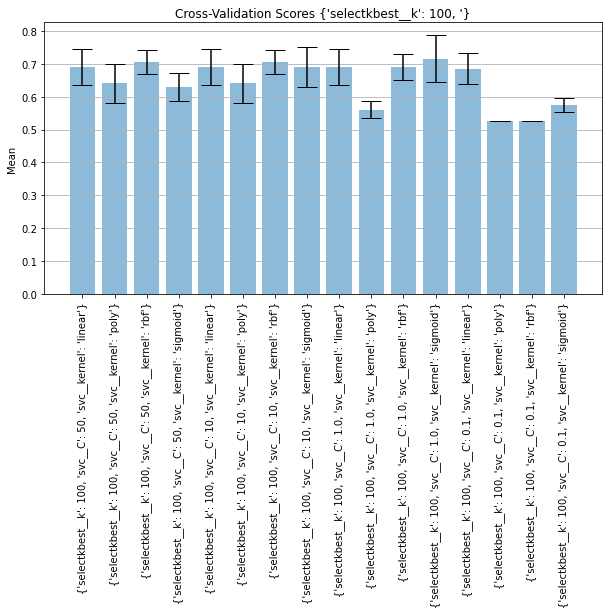

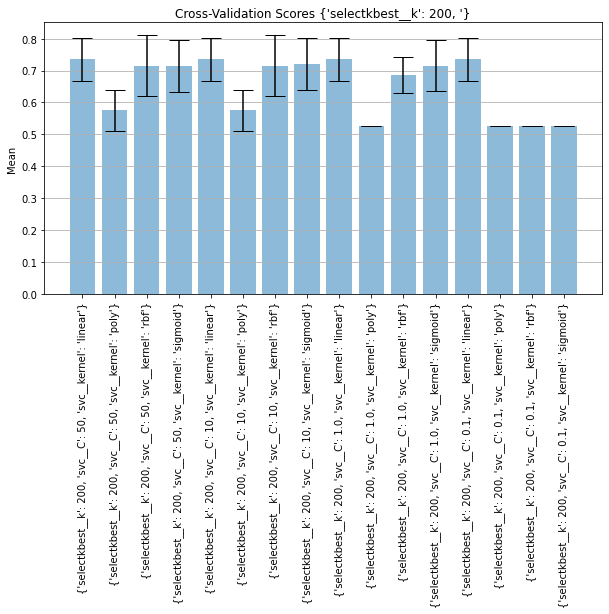

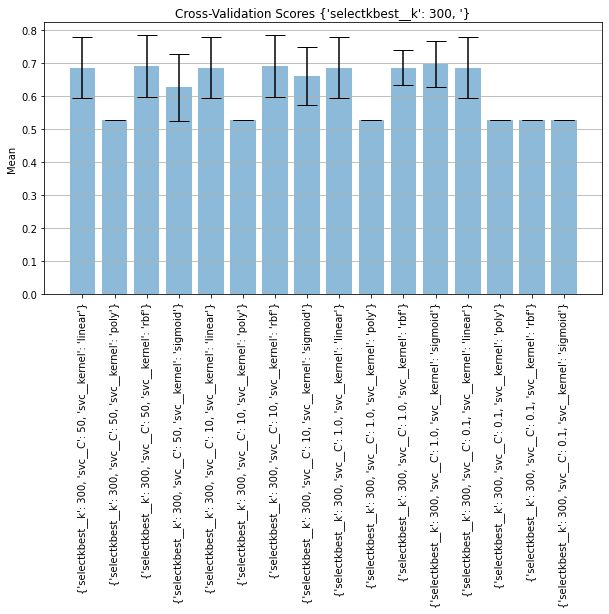

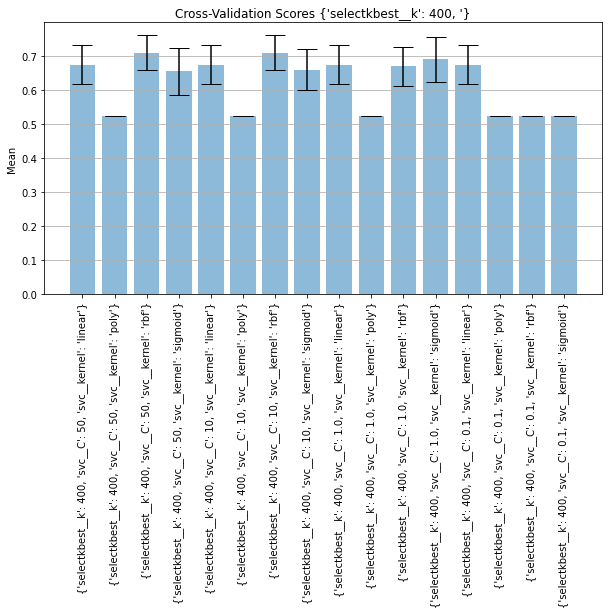

In [8]:
for i in range(0,len(grid_result.cv_results_['params']),16):
    fig, ax = plt.subplots(figsize=(10,5))
    ax.bar(np.arange(len(grid_result.cv_results_['params'][i:i+16])),
           grid_result.cv_results_['mean_test_score'][i:i+16],
           yerr=grid_result.cv_results_['std_test_score'][i:i+16],
           align='center', alpha=0.5, ecolor='black', capsize=10)
    ax.set_ylabel('Mean') 
    ax.set_xticks(np.arange(len(grid_result.cv_results_['params'][i:i+16])))
    ax.set_xticklabels(grid_result.cv_results_['params'][i:i+16], 
                       rotation=90)
    
    ax.set_title('Cross-Validation Scores '+str(grid_result.cv_results_['params'][i])[0:25]+'}')
    ax.yaxis.grid(True)

    #plt.savefig(r'D:\Maastricht\Machine Learning\Datasets\Dataset1\SVM'+str(i)+'.png',
               #dpi=300, bbox_inches='tight')
    plt.show()

# 3. K Nearest Neighbors

In [9]:
from sklearn.neighbors import KNeighborsClassifier

# make a pipeline to select features and apply K Nearest Neighbors Classifier 
KNN_pipeline = make_pipeline(SelectKBest(score_func=f_classif), KNeighborsClassifier())

# k = number of features to choose in SelectKBest
k_values = [100, 200, 300, 400]

# number of neighbors to use for k neighbors queries
n_neighbors = range(40, 80, 10)

# uniform: all points in each neighborhood are weighted equally.
# distance: weight points by the inverse of their distance. Closer neighbors of a query point 
# will have a greater influence than neighbors which are further away.
weights = ['uniform', 'distance']

# distance metric to measure nearset points
metric = ['euclidean', 'manhattan']

# 5-fold cross-validation 
cv = StratifiedKFold(n_splits=5)

grid = dict(kneighborsclassifier__n_neighbors=n_neighbors, 
            kneighborsclassifier__weights=weights, 
            kneighborsclassifier__metric=metric, 
            selectkbest__k=k_values)

# GridSearchCV exhaustively generates candidates from a grid of parameter values
grid_search = GridSearchCV(estimator=KNN_pipeline, param_grid=grid, n_jobs=-1, cv=cv, scoring='accuracy', error_score=0)
grid_result = grid_search.fit(X, y)

print("Best: %f using %s" % (grid_result.best_score_, grid_result.best_params_))

# define a K Nearest Neighbors model using the optimal parameter values obtained from the grid search
KNN_pipeline = make_pipeline(SelectKBest(score_func=f_classif, k=grid_result.best_params_['selectkbest__k']), 
                        KNeighborsClassifier(metric=grid_result.best_params_['kneighborsclassifier__metric'], 
                                n_neighbors=grid_result.best_params_['kneighborsclassifier__n_neighbors'],
                                             weights=grid_result.best_params_['kneighborsclassifier__weights']))

Best: 0.695000 using {'kneighborsclassifier__metric': 'euclidean', 'kneighborsclassifier__n_neighbors': 50, 'kneighborsclassifier__weights': 'uniform', 'selectkbest__k': 300}


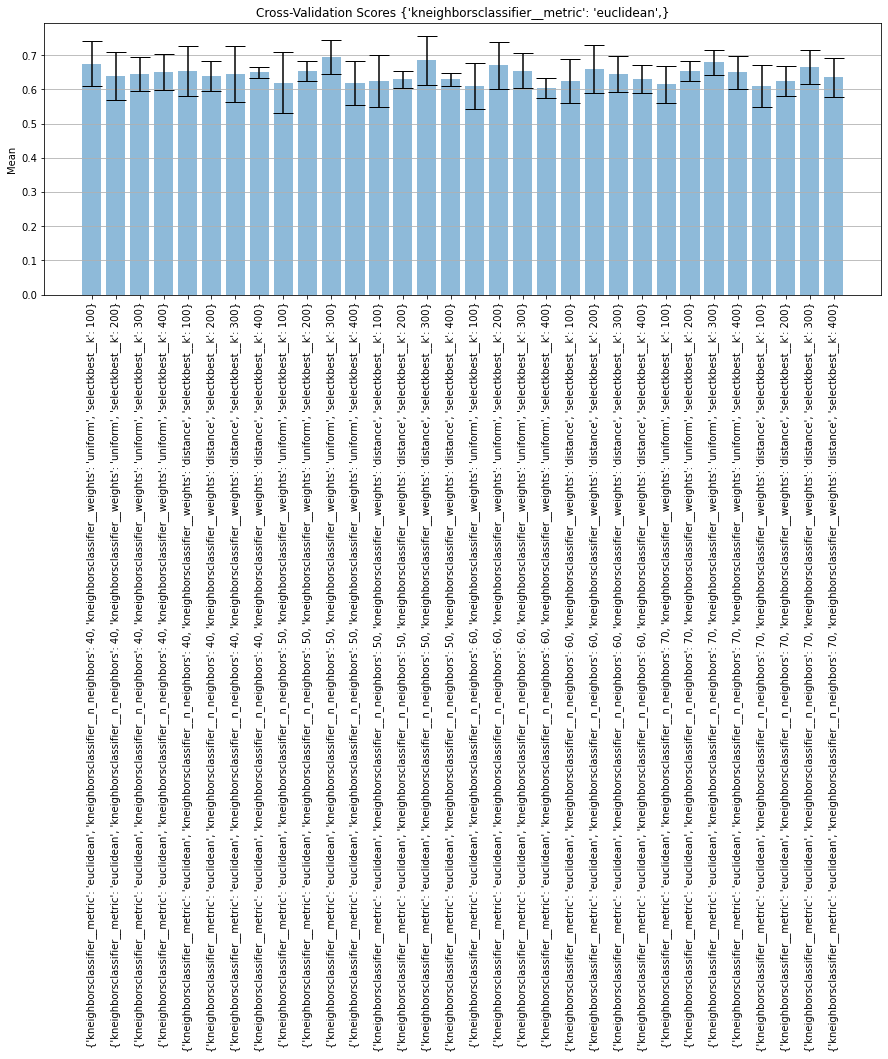

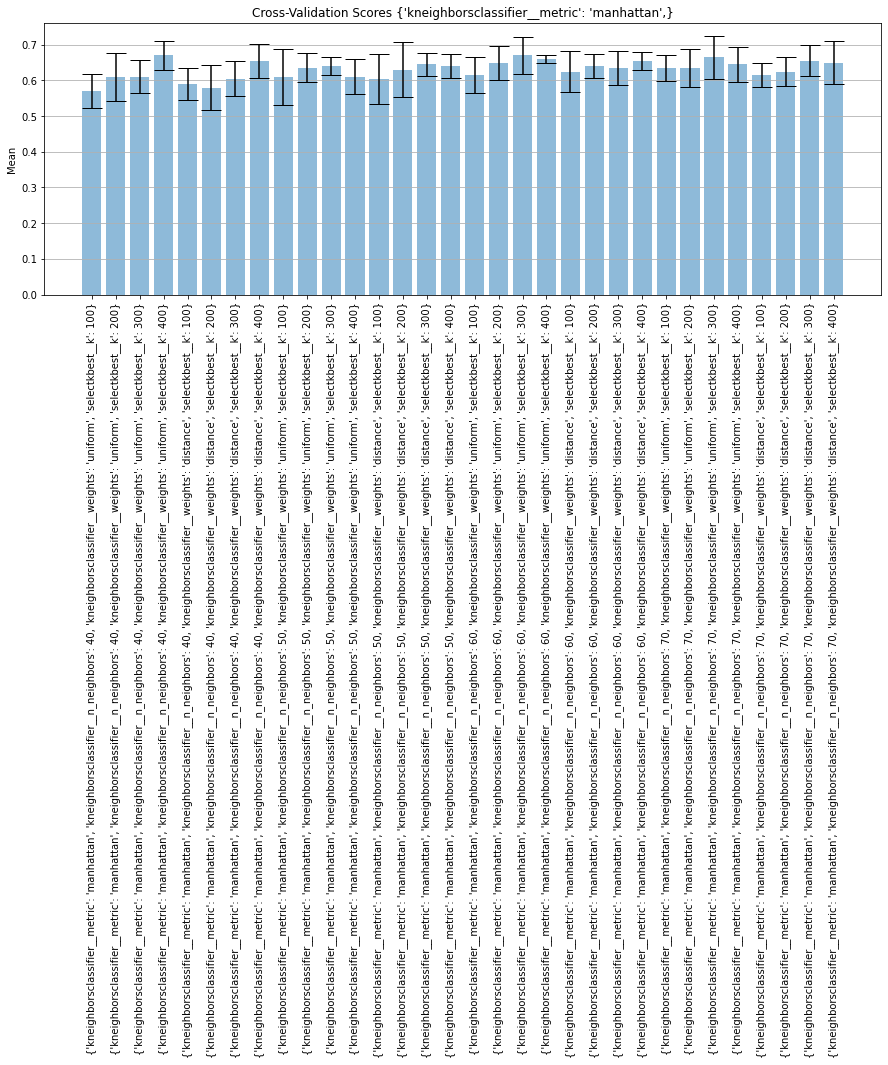

In [10]:
for i in range(0,len(grid_result.cv_results_['params']),32):
    fig, ax = plt.subplots(figsize=(15,5))
    ax.bar(np.arange(len(grid_result.cv_results_['params'][i:i+32])),
           grid_result.cv_results_['mean_test_score'][i:i+32],
           yerr=grid_result.cv_results_['std_test_score'][i:i+32],
           align='center', alpha=0.5, ecolor='black', capsize=10)
    ax.set_ylabel('Mean') 
    ax.set_xticks(np.arange(len(grid_result.cv_results_['params'][i:i+32])))
    ax.set_xticklabels(grid_result.cv_results_['params'][i:i+32], 
                       rotation=90)
    
    ax.set_title('Cross-Validation Scores '+str(grid_result.cv_results_['params'][i])[0:45]+'}')
    ax.yaxis.grid(True)

    #plt.savefig(r'D:\Maastricht\Machine Learning\Datasets\Dataset1\KNN'+str(i)+'.png',
               #dpi=300, bbox_inches='tight')
    plt.show()

# Train the best performing pipeline

Since the best performing pipeline is Logistic Regression with
`Best CV score: 0.765000 using {'logisticregression__C': 10, 'logisticregression__penalty': 'l1', 'selectkbest__k': 200}`,
this pipeline will now be trained on the whole dataset of 200 samples to obtain the best performing classifier model. This model will further be used to obtain labels for the test dataset.

In [11]:
# train the Logistic Regression pipeline
LR_pipeline.fit(X, y)

Pipeline(steps=[('selectkbest', SelectKBest(k=200)),
                ('logisticregression',
                 LogisticRegression(C=10, penalty='l1', random_state=20,
                                    solver='liblinear'))])

# Predict labels for the given test set

Xtest is a 1000 x 400 matrix whose target values are to be predicted using a trained model. It is first exported from MATLAB as a .csv file. 

It is imported into this notebook as follows.

In [12]:
# read csv files
Xtest = pd.read_csv("Xtest.csv", header=None) 

# print dimensions
print(Xtest.shape)

(1000, 400)


In [13]:
# print first few rows to ensure that data has been imported correctly

print(Xtest[:5])

        0         1         2         3         4         5         6    \
0 -0.387133 -0.139051  0.684266  0.462578 -1.512687 -0.290444  1.478716   
1  1.371503  1.594189  2.424634  0.191816 -1.844192 -1.025695 -0.506549   
2  0.673945 -0.101878  0.251442  1.961312  2.135035  0.396247 -0.099204   
3  0.091665  0.071445  0.318252  0.233176  0.396634 -1.363447 -1.036759   
4 -1.714202  1.098762  1.165892  1.526437  1.120687 -0.328555  0.898307   

        7         8         9    ...       390       391       392       393  \
0  1.232417  1.497342  0.495746  ... -0.051605  0.143637 -0.131707  0.109986   
1 -0.381485  0.291273 -0.665477  ... -1.015834  0.010146 -0.908166 -1.065227   
2  1.218904 -1.301087 -2.577274  ...  0.336924  0.432078  0.591224 -0.544107   
3 -0.847467  0.105416 -0.193551  ... -0.821785  0.162358 -1.529856 -2.135884   
4 -1.311722  0.490778  0.499929  ... -1.238582 -0.120849 -1.152873 -1.069462   

        394       395       396       397       398       399  
0  0

Because the Logistic Regression model is trained on normalized data, Xtest has to be normalized before predicting labels. This is done as follows.

In [14]:
scaler = preprocessing.StandardScaler().fit(Xtest)
Xtest = scaler.transform(Xtest)

The Logistic Regression model that was trained in the previous step will be used to predict the labels for the test set.

In [22]:
# predict labels for the test set using Logistic Regression model
y_pred = LR_pipeline.predict(Xtest)

# check dimensions of the predicted labels vector
print(y_pred.shape)

(1000,)


In [23]:
y_pred = pd.DataFrame(y_pred)

y_pred.to_csv(r'D:\Maastricht\Machine Learning\Datasets\Dataset1\y_pred.csv', header=False, index=False)